In [26]:
# ! uv pip install -q transformers accelerate peft bitsandbytes datasets matplotlib

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import List, Dict

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
from datasets import load_dataset

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Choices: 7B model + actual dataset

#### 1.1 Choose a 7B-ish instruct model

In [6]:
# Example choices (pick one that you know you can run):
# MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
# MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"

# MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"


#### Bits and Bytes Config, for quantization and loading a model

In [7]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",  # spread across available GPUs if needed
)
model.eval()

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm

In [27]:
print("Model loaded on:", model.device)
print("Pad token:", tokenizer.pad_token, tokenizer.pad_token_id)

Model loaded on: cuda:0
Pad token: <|endoftext|> 151643


#### 1.2 Load a real dataset (amazon_polarity)

In [ ]:
raw_ds = load_dataset("tatsu-lab/alpaca")
raw_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

In [30]:
def show_example(idx=0):
    ex = raw_ds["train"][idx]
    # print(ex)
    print(f"Label:\n{ex['label']}\n")
    print(f"Title:\n{ex['title']}\n")
    print(f"Content:\n{ex['content']}")

show_example(0)

Label:
1

Title:
Stuning even for the non-gamer

Content:
This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^


#### 1.3 Create a small dataset

Turn dataset into instruction–response pairs

In [31]:
label_map = {0: "negative", 1: "positive"}

In [ ]:
def format_example(ex):
    # basic, readable instruction format
    text = ex["content"].strip().replace("\n", " ")
    label = label_map[ex["label"]]
    return {
        "instruction": (
            "You are a sentiment classifier. "
            "Read the following product review and answer with 'positive' or 'negative'.\n\n"
            f"Review: {text}"
        ),
        "response": f"The sentiment is {label}.",
        "label": label,
    }

# Take a small subset to keep everything fast & visually inspectable
train_small = raw_ds["train"].select(range(256)).map(format_example)
test_small  = raw_ds["test"].select(range(64)).map(format_example)

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

In [34]:
print("Example processed row:")
print(train_small[0]["instruction"])
print("---")
print(train_small[0]["response"])

Example processed row:
You are a sentiment classifier. Read the following product review and answer with 'positive' or 'negative'.

Review: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
---
The sentiment is positive.


### 2. Testing the model, just pure inference

In [35]:
def generate(model, tokenizer, prompt: str, max_new_tokens: int = 128):
    print("=" * 100)
    print("PROMPT:")
    print(prompt)
    print("-" * 100)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
        )
    full_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print("FULL MODEL OUTPUT:")
    print(full_text)
    print("=" * 100)
    print()



#### 2.1 Testing the model on generic prompts

In [36]:
manual_prompts = [
    "Explain overfitting in one sentence.",
    "Add 2 and 7.",
    "Translate 'hello' to French.",
    "Is the number 17 even or odd?",
]

for p in manual_prompts:
    generate(model, tokenizer, p)


PROMPT:
Explain overfitting in one sentence.
----------------------------------------------------------------------------------------------------
FULL MODEL OUTPUT:
Explain overfitting in one sentence. Overfitting occurs when a machine learning model learns the noise and details in the training data to such an extent that it performs well on the training data but poorly on new, unseen data.

PROMPT:
Add 2 and 7.
----------------------------------------------------------------------------------------------------
FULL MODEL OUTPUT:
Add 2 and 7. The sum of 2 and 7 is 9. This can be calculated as follows:

\[ 2 + 7 = 9 \] 

Thus, the final answer is \(\boxed{9}\).

PROMPT:
Translate 'hello' to French.
----------------------------------------------------------------------------------------------------
FULL MODEL OUTPUT:
Translate 'hello' to French. The translation of 'hello' to French is 'bonjour'.

PROMPT:
Is the number 17 even or odd?
------------------------------------------------------

#### 2.2 On our amazon dataset(instruction pairs)

In [37]:
for i in range(3):
    ex = train_small[i]
    generate(model, tokenizer, ex["instruction"], max_new_tokens=64)

PROMPT:
You are a sentiment classifier. Read the following product review and answer with 'positive' or 'negative'.

Review: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
----------------------------------------------------------------------------------------------------
FULL MODEL OUTPUT:
You are a sentiment classifier. Read the following product review and answer with 'positive' or 'negative'.

Review: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It

#### 2.3 Build instruction–tuning text & inspect tokenization

In [40]:
def to_training_text(ex: Dict[str, str]) -> str:
    instr = ex["instruction"].strip()
    resp = ex["response"].strip()
    text = f"Instruction: {instr}\nResponse: {resp}"
    return text

texts_train = [to_training_text(ex) for ex in train_small]
texts_test  = [to_training_text(ex) for ex in test_small]

print("Example training text:\n")
print(texts_train[0])


Example training text:

Instruction: You are a sentiment classifier. Read the following product review and answer with 'positive' or 'negative'.

Review: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
Response: The sentiment is positive.


In [41]:
tokenized = tokenizer(
    texts_train[:8],          # first 8 examples for inspection
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt",
)


In [42]:
input_ids = tokenized["input_ids"]
attention_mask = tokenized["attention_mask"]

In [43]:
print("input_ids shape:", input_ids.shape)           # (batch_size, seq_len)
print("attention_mask shape:", attention_mask.shape)

input_ids shape: torch.Size([8, 212])
attention_mask shape: torch.Size([8, 212])


In [44]:


# Let's visualize the first example token-by-token
def visualize_tokenization(example_idx: int = 0):
    ids = input_ids[example_idx]
    mask = attention_mask[example_idx]
    print(f"Sequence {example_idx} (effective length = {mask.sum().item()} tokens):")
    print("pos | id      | mask | token")
    print("-" * 60)
    for i, (tid, m) in enumerate(zip(ids, mask)):
        token_str = tokenizer.decode([int(tid)])
        print(f"{i:03d} | {int(tid):7d} |  {int(m)}   | {repr(token_str)}")

visualize_tokenization(0)

Sequence 0 (effective length = 121 tokens):
pos | id      | mask | token
------------------------------------------------------------
000 |   16664 |  1   | 'Instruction'
001 |      25 |  1   | ':'
002 |    1446 |  1   | ' You'
003 |     525 |  1   | ' are'
004 |     264 |  1   | ' a'
005 |   25975 |  1   | ' sentiment'
006 |   33365 |  1   | ' classifier'
007 |      13 |  1   | '.'
008 |    4457 |  1   | ' Read'
009 |     279 |  1   | ' the'
010 |    2701 |  1   | ' following'
011 |    1985 |  1   | ' product'
012 |    3395 |  1   | ' review'
013 |     323 |  1   | ' and'
014 |    4226 |  1   | ' answer'
015 |     448 |  1   | ' with'
016 |     364 |  1   | " '"
017 |   30487 |  1   | 'positive'
018 |       6 |  1   | "'"
019 |     476 |  1   | ' or'
020 |     364 |  1   | " '"
021 |   42224 |  1   | 'negative'
022 |   29636 |  1   | "'.\n\n"
023 |   19432 |  1   | 'Review'
024 |      25 |  1   | ':'
025 |    1096 |  1   | ' This'
026 |    5112 |  1   | ' sound'
027 |    3754 |  1   |

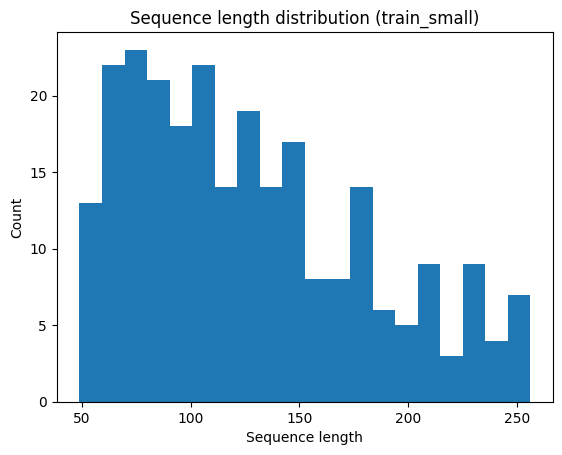

In [45]:
tokenized_lengths = tokenizer(
    texts_train,
    truncation=True,
    max_length=256,
)["input_ids"]

lengths = [len(ids) for ids in tokenized_lengths]

plt.hist(lengths, bins=20)
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.title("Sequence length distribution (train_small)")
plt.show()


### Build labels, explain causal LM objective 
For a sequence of tokens [x0, x1, x2, ..., xT], the model learns to predict:

x1 given x0

x2 given [x0, x1]

…

xT given [x0, ..., x_{T-1}]

We implement the standard HF style:

Use the same input_ids as input.

Use labels = input_ids.clone().

Set labels = -100 wherever we want to ignore tokens in the loss (padding).

In [46]:
# Start from our existing batch (input_ids, attention_mask)
labels = input_ids.clone()

# Mask out padding positions from the loss:
labels[attention_mask == 0] = -100  # -100 is "ignore index" for CrossEntropyLoss

print("labels shape:", labels.shape)
print("Supervised tokens:", (labels != -100).sum().item())
print("Total tokens:", labels.numel())
print("Supervision ratio:", (labels != -100).float().mean().item())


labels shape: torch.Size([8, 212])
Supervised tokens: 1385
Total tokens: 1696
Supervision ratio: 0.8166273832321167


In [47]:
def inspect_input_and_labels(idx: int = 0):
    ids = input_ids[idx]
    labs = labels[idx]
    mask = attention_mask[idx]
    print(f"=== Example {idx} ===")
    print("pos | input_id | label_id | mask | input_tok             | label_tok")
    print("-" * 90)
    for i, (tid, lid, m) in enumerate(zip(ids, labs, mask)):
        input_tok = tokenizer.decode([int(tid)]) if int(tid) != tokenizer.pad_token_id else "<PAD>"
        if int(lid) == -100:
            label_tok = "<IGNORED>"
        else:
            label_tok = tokenizer.decode([int(lid)])
        print(
            f"{i:03d} | {int(tid):8d} | {int(lid):8d} |  {int(m)}   | {input_tok!r:20s} | {label_tok!r}"
        )

inspect_input_and_labels(0)


=== Example 0 ===
pos | input_id | label_id | mask | input_tok             | label_tok
------------------------------------------------------------------------------------------
000 |    16664 |    16664 |  1   | 'Instruction'        | 'Instruction'
001 |       25 |       25 |  1   | ':'                  | ':'
002 |     1446 |     1446 |  1   | ' You'               | ' You'
003 |      525 |      525 |  1   | ' are'               | ' are'
004 |      264 |      264 |  1   | ' a'                 | ' a'
005 |    25975 |    25975 |  1   | ' sentiment'         | ' sentiment'
006 |    33365 |    33365 |  1   | ' classifier'        | ' classifier'
007 |       13 |       13 |  1   | '.'                  | '.'
008 |     4457 |     4457 |  1   | ' Read'              | ' Read'
009 |      279 |      279 |  1   | ' the'               | ' the'
010 |     2701 |     2701 |  1   | ' following'         | ' following'
011 |     1985 |     1985 |  1   | ' product'           | ' product'
012 |     3395 |   

#### Manually compute per-token loss on a single example

In [48]:
model.eval()
with torch.no_grad():
    outputs = model(
        input_ids=input_ids.to(device),
        attention_mask=attention_mask.to(device),
    )
    logits = outputs.logits  # (batch_size, seq_len, vocab_size)

logits.shape


torch.Size([8, 212, 152064])

In [49]:
example_idx = 0

logits_ex = logits[example_idx].cpu()         # (seq_len, vocab)
labels_ex = labels[example_idx].cpu()         # (seq_len)
mask_ex   = attention_mask[example_idx].cpu() # (seq_len)

seq_len = logits_ex.size(0)

log_probs = torch.log_softmax(logits_ex, dim=-1)  # (seq_len, vocab)
losses = []

for t in range(seq_len):
    if labels_ex[t].item() == -100:
        losses.append(np.nan)      # padding / ignored
    else:
        losses.append(-log_probs[t, labels_ex[t]].item())

losses = np.array(losses)
losses[:10]


array([ 9.15625  , 17.8125   , 17.609375 , 11.90625  ,  8.6640625,
       11.0234375, 12.6875   , 20.578125 , 18.78125  ,  9.046875 ])

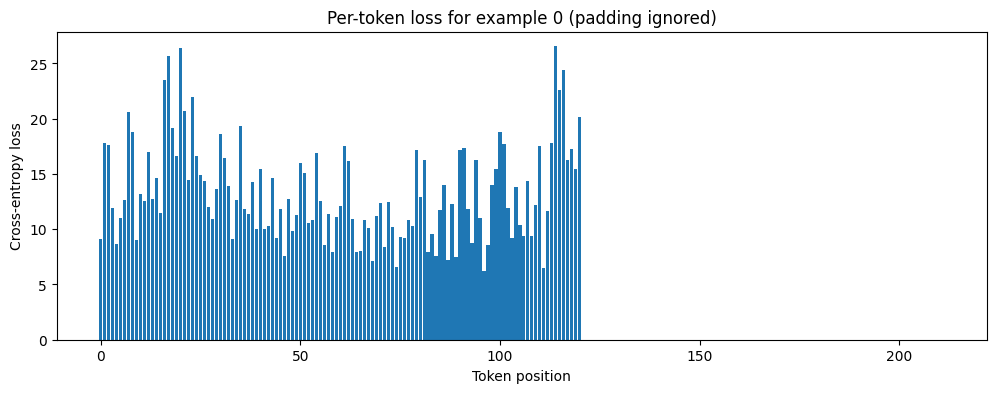

In [50]:
plt.figure(figsize=(12, 4))
plt.bar(np.arange(seq_len), np.nan_to_num(losses, nan=0.0))
plt.xlabel("Token position")
plt.ylabel("Cross-entropy loss")
plt.title("Per-token loss for example 0 (padding ignored)")
plt.show()


### Intuition for causal mask (optional but nice)

In [51]:
def build_causal_mask(seq_len: int):
    # 1 means allowed attention, 0 means masked
    return torch.tril(torch.ones(seq_len, seq_len))

L = 10
causal = build_causal_mask(L)
print(causal)


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
